### Import & Setup

In [111]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [112]:
image_frame_dark = cv2.imread("Data/capcha-black.png")
image_frame_light = cv2.imread("Data/capcha-blank.png")
image1 = cv2.imread("Data/captcha-1.png")
image2 = cv2.imread("Data/captcha-2.png")
image3 = cv2.imread("Data/captcha-3.png")
image_complex = cv2.imread("Data/captcha-complex.png")

### Erase Frame

remove the top frame and grid between the image.

In [113]:
import cv2
import numpy as np

def erase_frame(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    result = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(mask))
    return result

def remove_grids(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 4))
    morphed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    _, binary = cv2.threshold(morphed, 200, 255, cv2.THRESH_BINARY_INV)
    return binary


In [114]:
def extract_objects(image, col, rows):
    if len(image.shape) == 2: 
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    h, w, _ = image.shape
    cell_h, cell_w = h // rows, w // col

    objects = []
    for i in range(rows):
        for j in range(col):
            obj = image[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]
            objects.append(obj)
    return objects


In [129]:
def filter_significant_objects(objects, percentile_threshold=30):
    counts = []
    
    # Calculate white pixel count for each object
    new_objects = objects[5:20]
    for i, obj in enumerate(new_objects):
        gray_obj = cv2.cvtColor(obj, cv2.COLOR_BGR2GRAY)
        white_pixel_count = cv2.countNonZero(gray_obj)
        counts.append((i, white_pixel_count))
    
    # Sort objects by white pixel count
    counts.sort(key=lambda x: x[1])
    
    # Calculate the threshold based on the given percentile
    threshold = np.percentile([count[1] for count in counts], percentile_threshold)
    
    # Filter objects with significant white pixel counts
    significant_objects = [obj for obj in counts if obj[1] > threshold]
    
    # Save significant objects and print their indices
    print("Selected objects:")
    for obj in significant_objects:
        index = obj[0] 
        print(f"Figure {index+5}")
    
    return [obj[0] for obj in significant_objects]

hard to erase the entire frame, so we will remove the bottom part of the image with the test frame because all the bottom parts are the same. While the top frame is different with words.

white picture to detect the completeness of the frame.

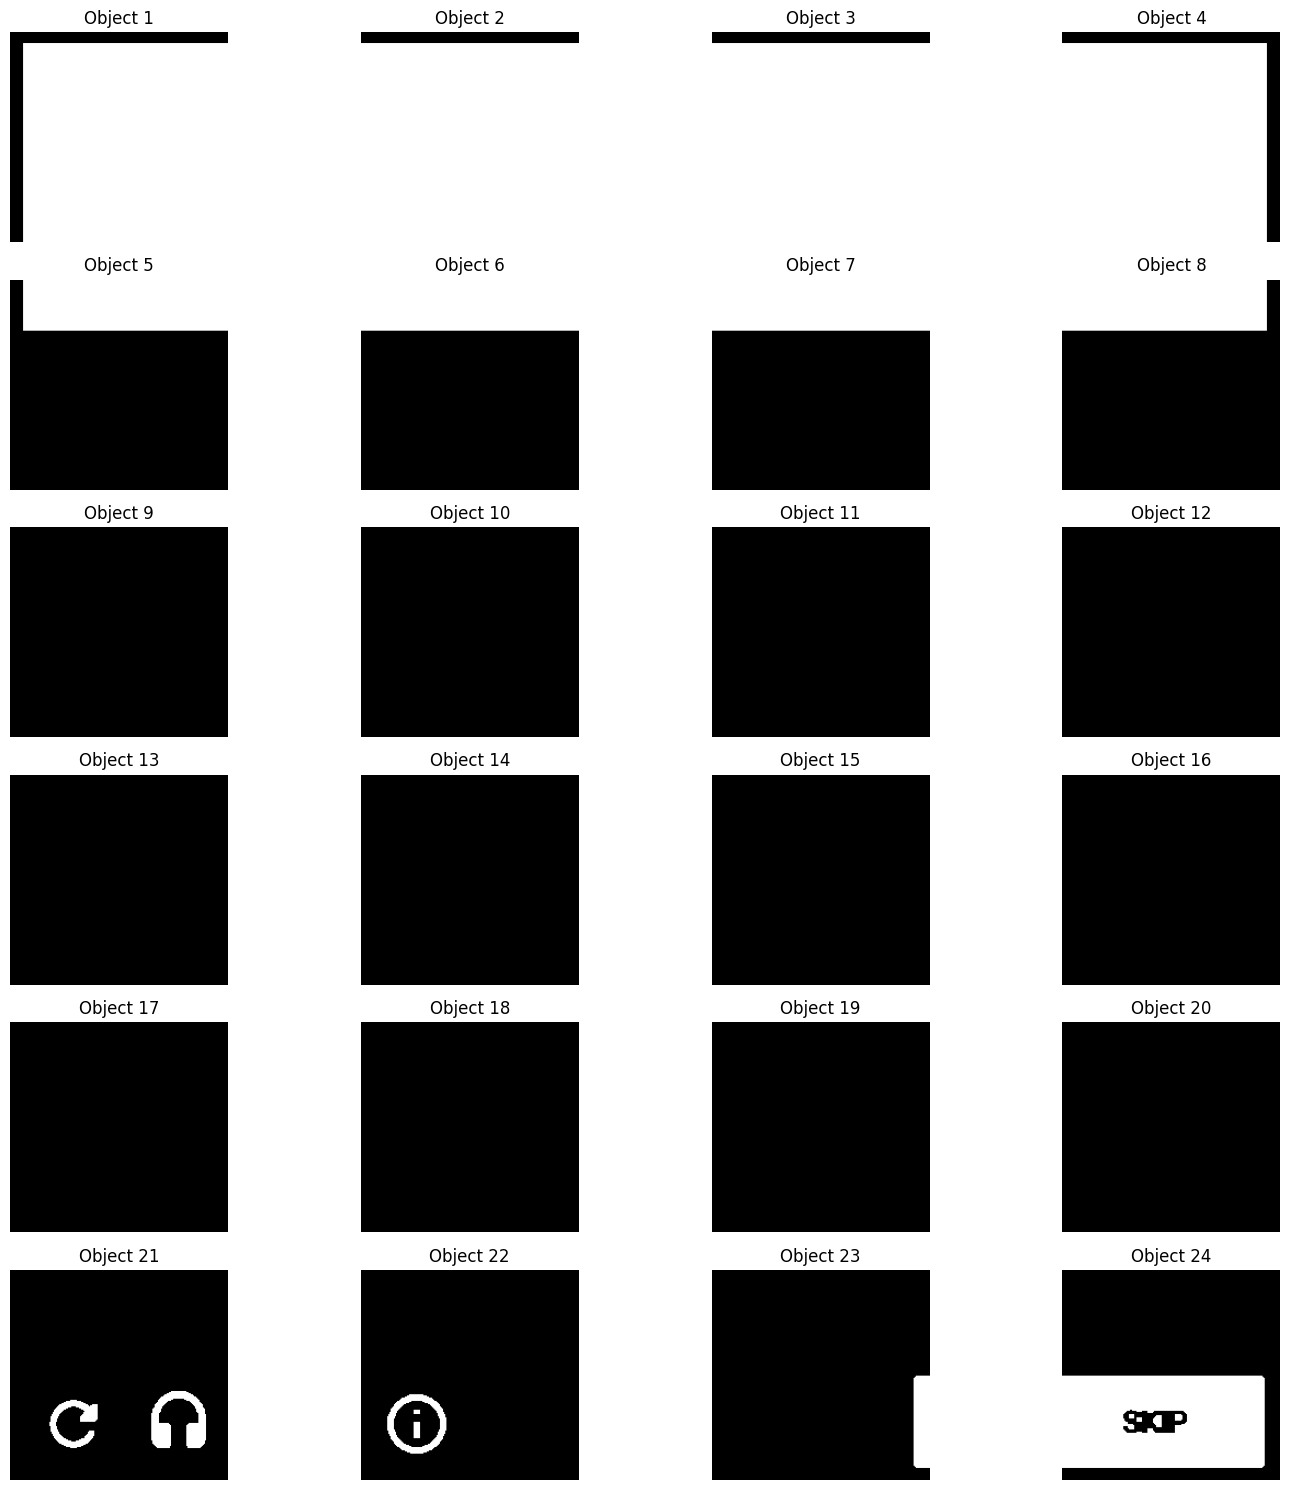

In [130]:
no_frame = erase_frame(image_frame_light)
no_grids = remove_grids(no_frame)
cols = 4 
rows = 6
objects = extract_objects(no_grids, cols, rows)

num_objects = len(objects)

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for i, obj in enumerate(objects):
    axes[i].imshow(cv2.cvtColor(obj, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Object {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

dark picture to detect grid lines.

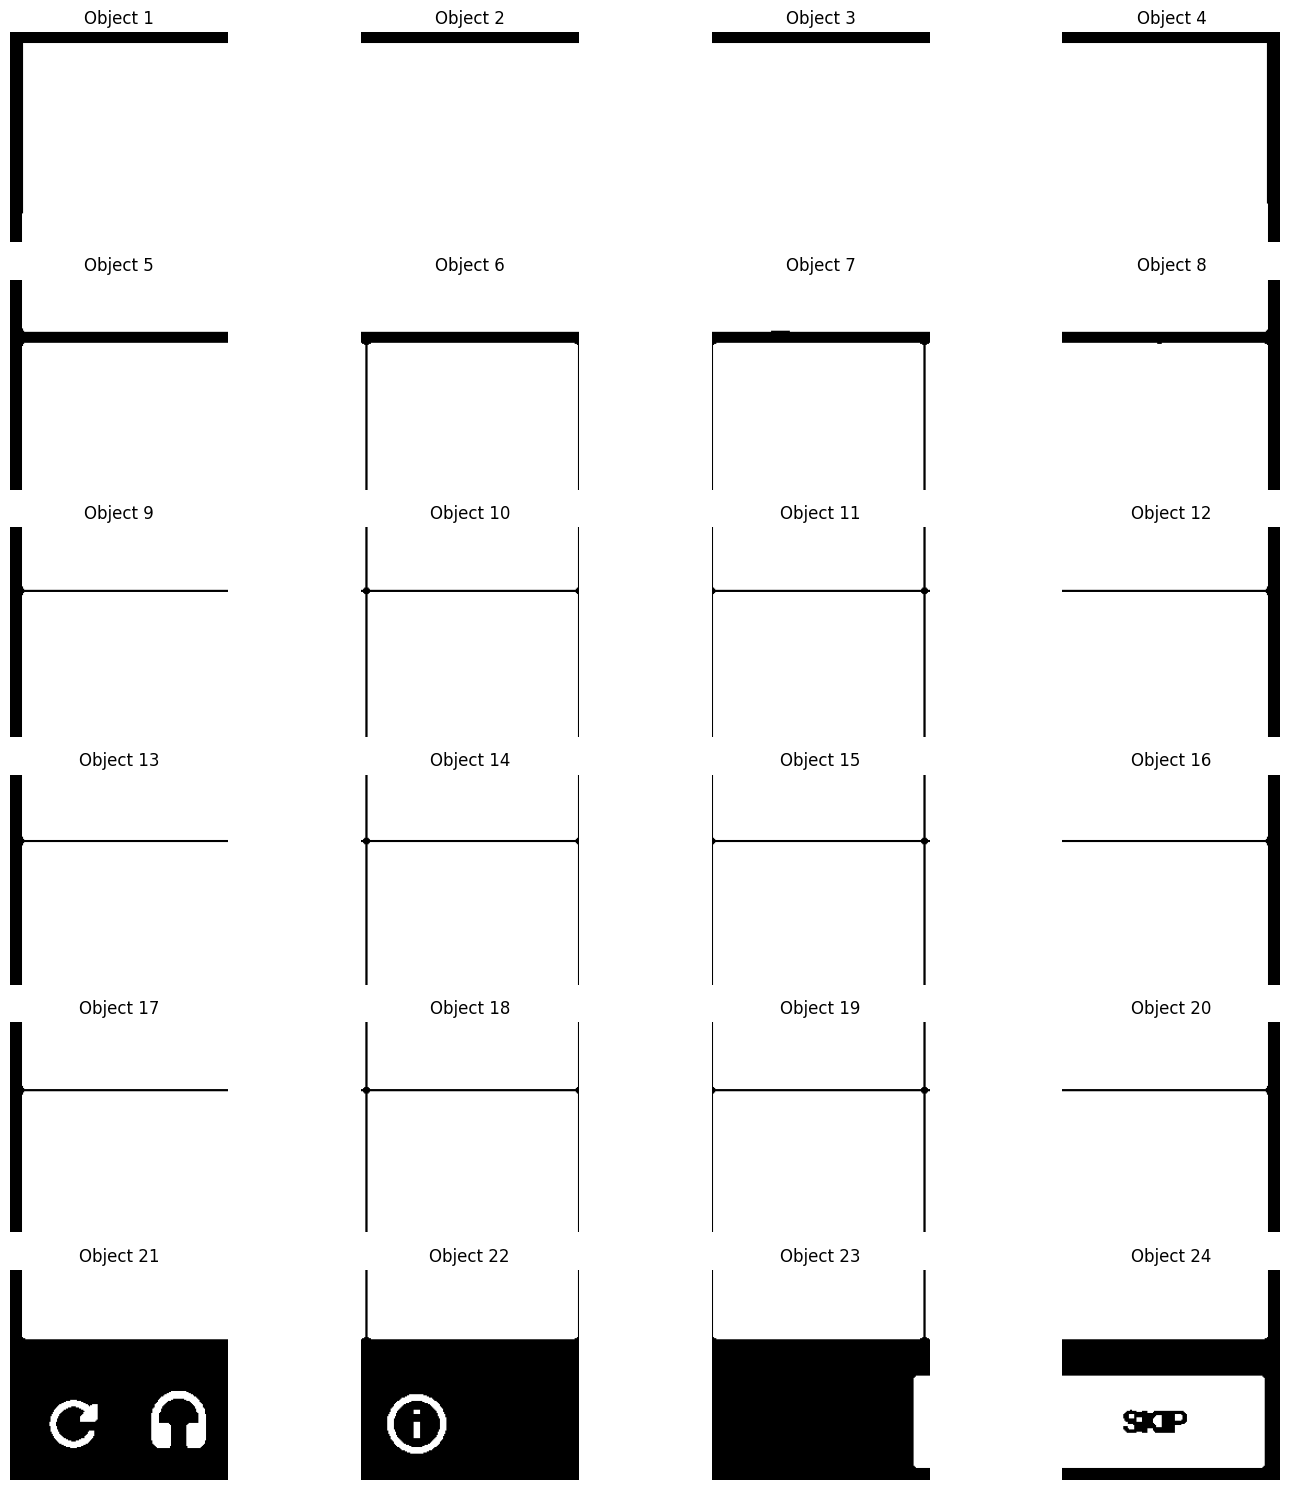

In [131]:
no_frame = erase_frame(image_frame_dark)
no_grids = remove_grids(no_frame)
cols = 4 
rows = 6
objects = extract_objects(no_grids, cols, rows)

num_objects = len(objects)

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for i, obj in enumerate(objects):
    axes[i].imshow(cv2.cvtColor(obj, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Object {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

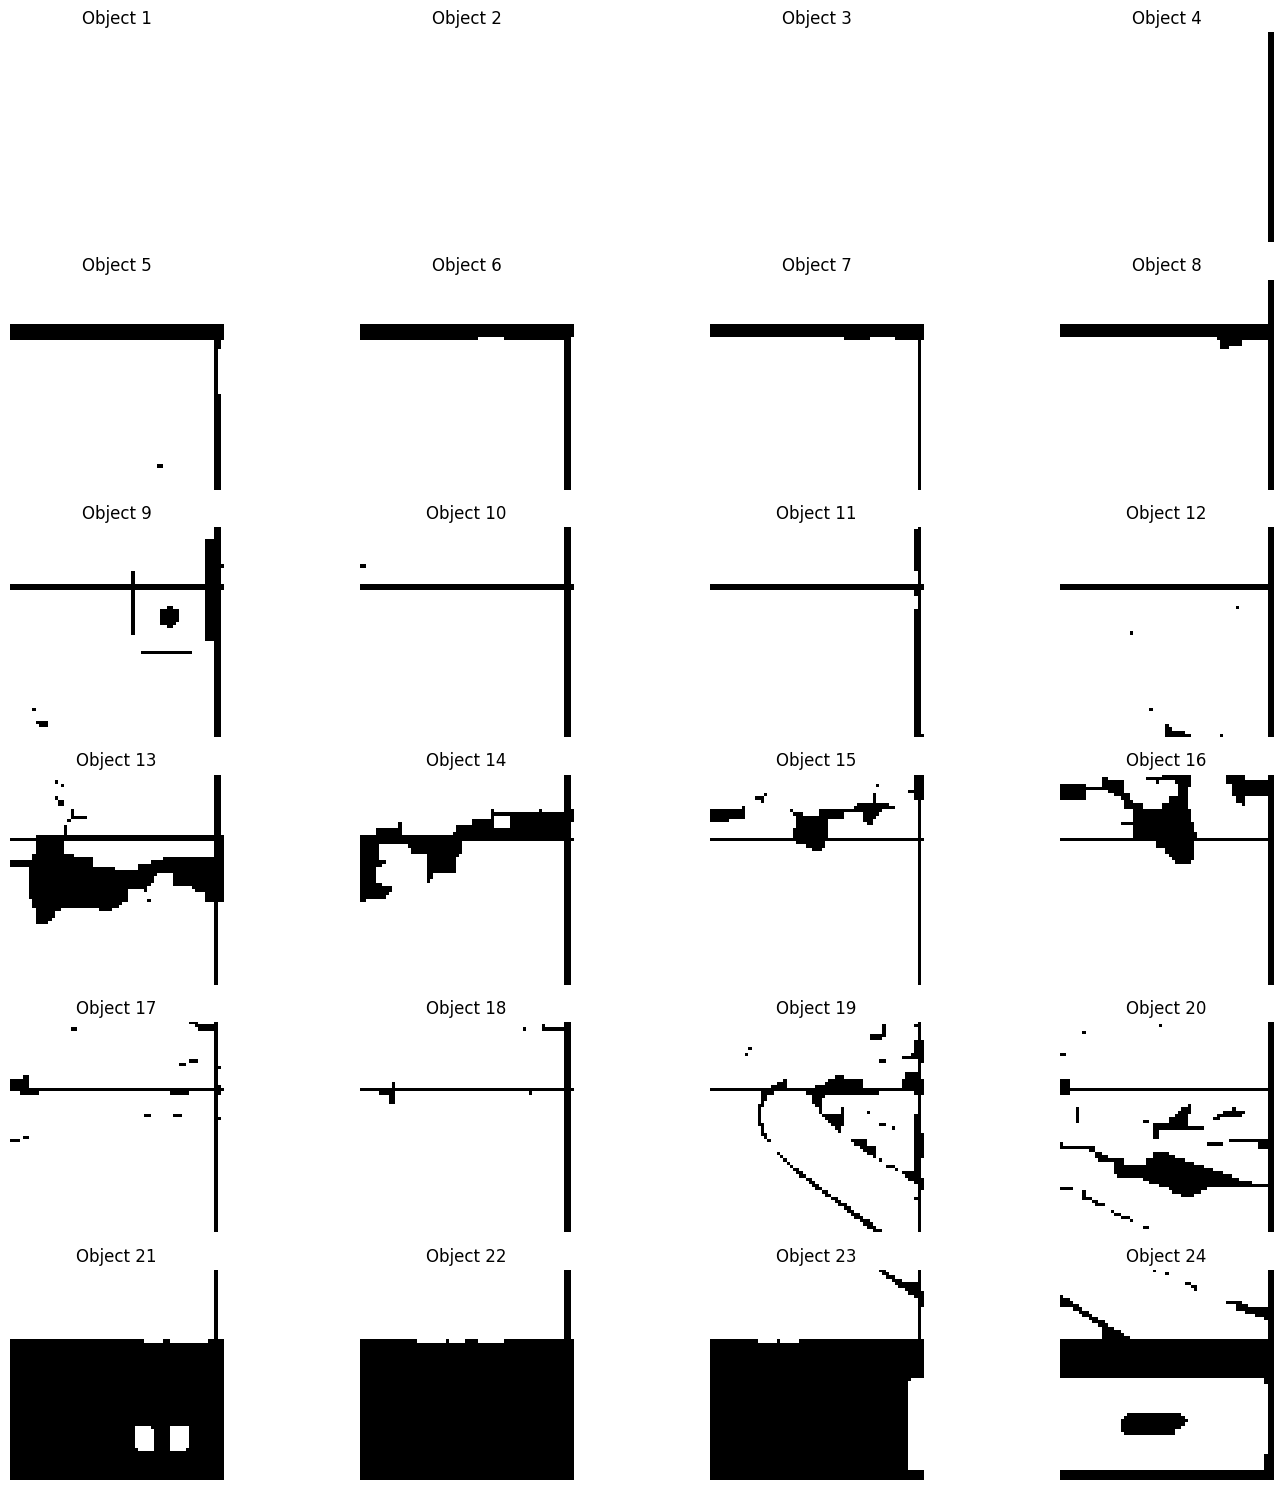

Selected objects:
Figure 13
Figure 15
Figure 19
Figure 18
Figure 8
Figure 7
Figure 5
Figure 14
Figure 6
Figure 11
Figure 9
Figure 10
Figure 17
Figure 16


[8, 10, 14, 13, 3, 2, 0, 9, 1, 6, 4, 5, 12, 11]

In [134]:
no_frame = erase_frame(image1)
no_grids = remove_grids(no_frame)
cols = 4 
rows = 6
objects = extract_objects(no_grids, cols, rows)

num_objects = len(objects)

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for i, obj in enumerate(objects):
    axes[i].imshow(cv2.cvtColor(obj, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Object {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

filter_significant_objects(objects, percentile_threshold=0)

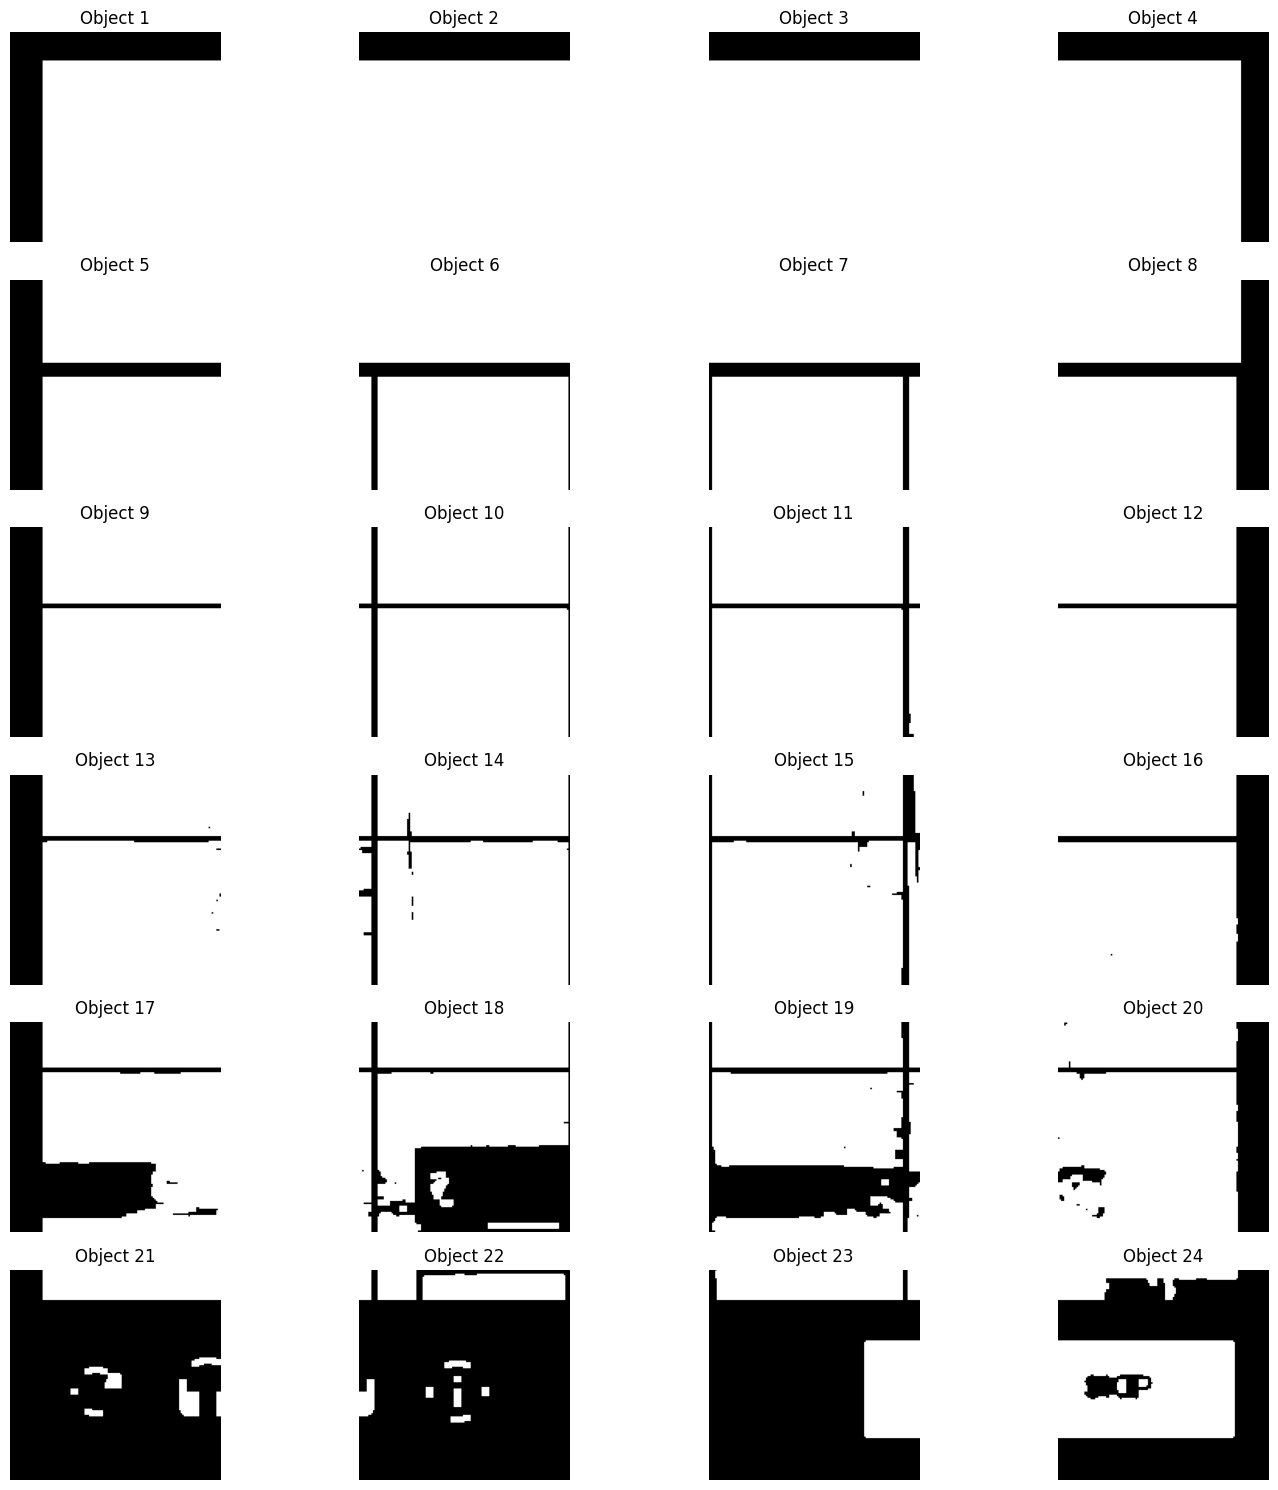

Selected objects:
Figure 6
Figure 5
Figure 14
Figure 13
Figure 10
Figure 9


[1, 0, 9, 8, 5, 4]

In [141]:
no_frame = erase_frame(image2)
no_grids = remove_grids(no_frame)
cols = 4 
rows = 6
objects = extract_objects(no_grids, cols, rows)

num_objects = len(objects)

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for i, obj in enumerate(objects):
    axes[i].imshow(cv2.cvtColor(obj, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Object {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

filter_significant_objects(objects, percentile_threshold=50)

The above work only works for complex cases. For simple cases, it detects the border as an object. Another problem is that the image is not clear enough to detect the objects. So we need to use a different method to detect the objects. Also, the corp isnt done, there exists a big section in the each figure that contains sections from above. 

Use Bounding box to detect grids to separate the images.

In [142]:
def debug_bounding_boxes(image, bounding_boxes):
    debug_image = image.copy()
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(debug_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Bounding Boxes")
    plt.axis("off")
    plt.show()


In [143]:
def plot_bounding_boxes_as_figures(image, bounding_boxes):
    image_with_boxes = image.copy()

    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Image with Bounding Boxes")
    plt.show()

In [158]:
def filter_bounding_boxes(image, bounding_boxes):
    # Get the dimensions of the image
    img_height, img_width = image.shape[:2]
    
    # Calculate the minimum width and height for a 4x4 grid
    min_width = img_width // 4
    min_height = img_height // 6
    
    # Filter bounding boxes that meet the minimum size criteria
    valid_boxes = [
        box for box in bounding_boxes
        if (box[2] - box[0] >= min_width) and (box[3] - box[1] >= min_height)
    ]
    
    return valid_boxes

In [160]:
def extract_objects2(image, cols, rows):
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    edges = cv2.Canny(cleaned, 50, 150)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    filtered_boxes = [
        b for b in bounding_boxes if 50 < b[2] < 200 and 50 < b[3] < 200
    ] 
    
    filtered_boxes = sorted(filtered_boxes, key=lambda b: (b[1], b[0]))
    
    print(f"Filtered bounding boxes: {len(filtered_boxes)}")
    plot_bounding_boxes_as_figures(image, filtered_boxes)
    if len(filtered_boxes) != cols * rows:
        raise ValueError("extra grids")
    
    # Extract objects
    objects = []
    for x, y, w, h in filtered_boxes:
        cropped = image[y:y+h, x:x+w]
        objects.append(cropped)
    
    return objects

In [161]:
def filter_bounding_boxes(bounding_boxes, min_area, max_area, max_boxes):
    filtered_boxes = []

    for box in bounding_boxes:
        # Ensure the box has exactly 4 elements
        if len(box) != 4:
            print(f"Skipping invalid box: {box}")
            continue

        x, y, w, h = box
        area = w * h

        # Apply area constraints
        if min_area <= area <= max_area:
            filtered_boxes.append(box)

    # Limit the number of boxes to max_boxes
    return filtered_boxes[:max_boxes]

Filtered bounding boxes: 18


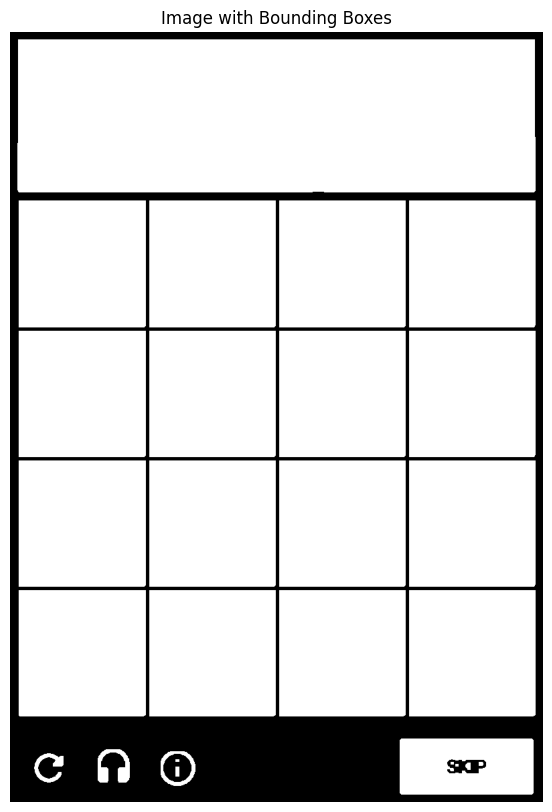

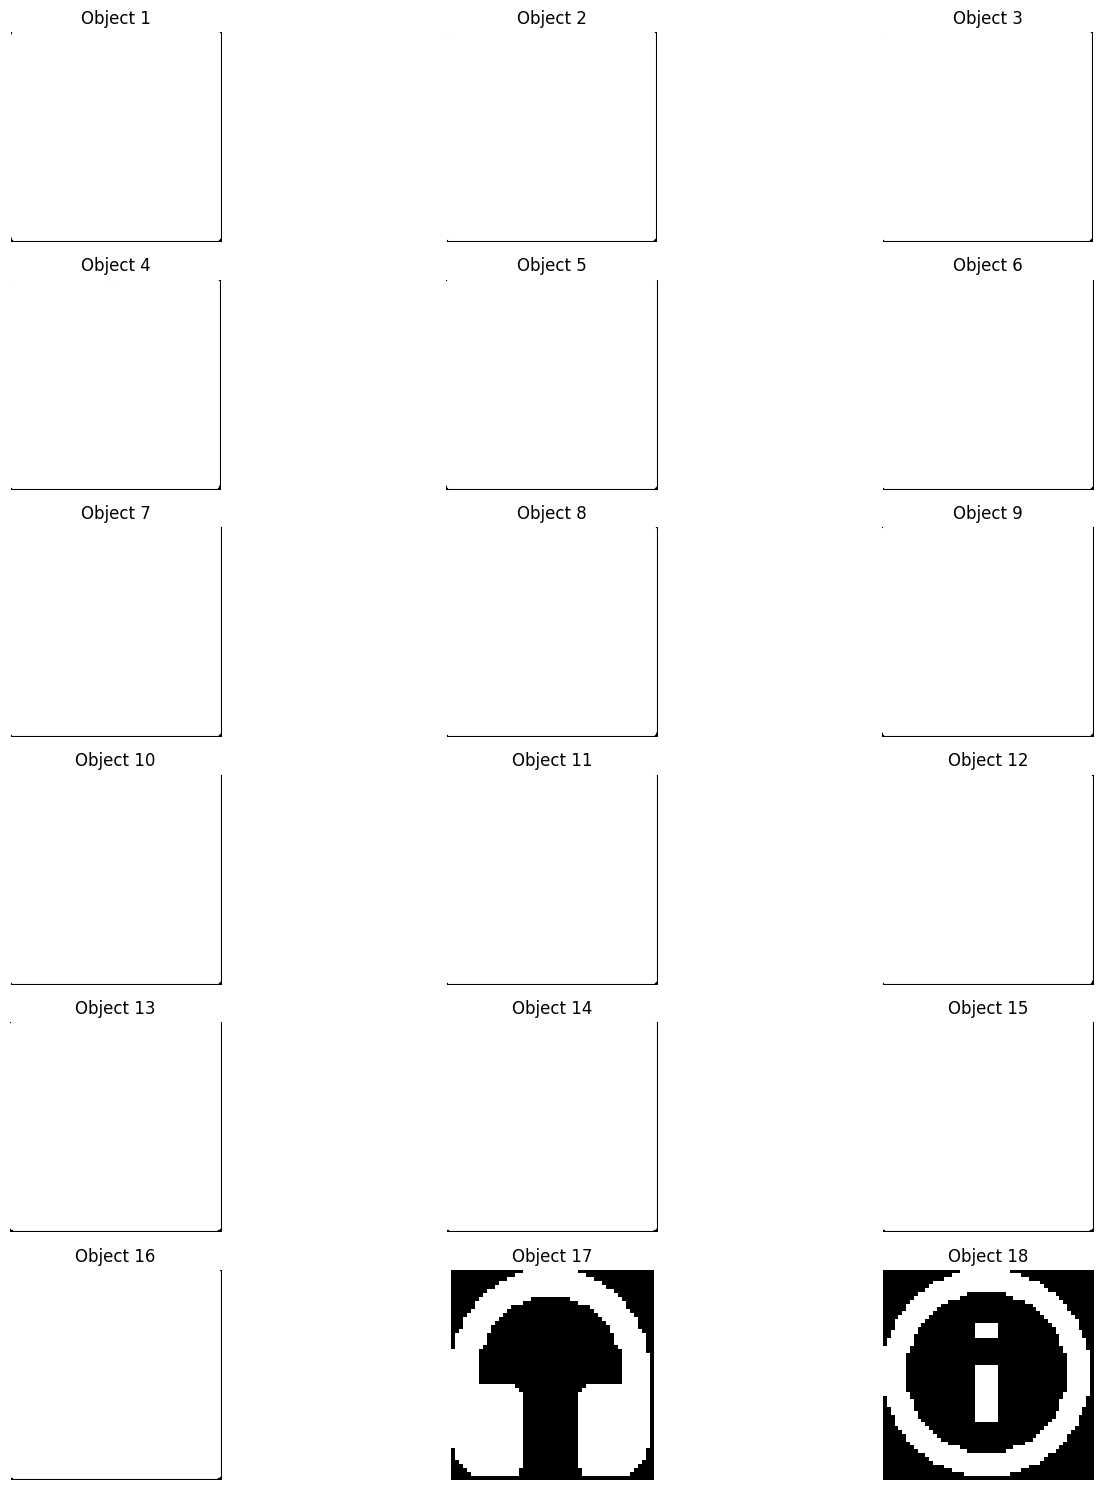

In [162]:
no_frame = erase_frame(image_frame_dark)
no_grids = remove_grids(no_frame)
cols = 3
rows = 6
objects = extract_objects2(no_grids, cols, rows)

# Ensure the number of subplots matches the number of objects
num_objects = len(objects)
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

# Adjust the loop to avoid IndexError
for i, obj in enumerate(objects[:len(axes)]):
    axes[i].imshow(cv2.cvtColor(obj, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Object {i + 1}')
    axes[i].axis('off')

# Hide unused subplots
for ax in axes[len(objects):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

this is a perfect example of how to detect the grids. all grids are deteced . we only need the first 16 objects to detect the grids.

Filtered bounding boxes: 17


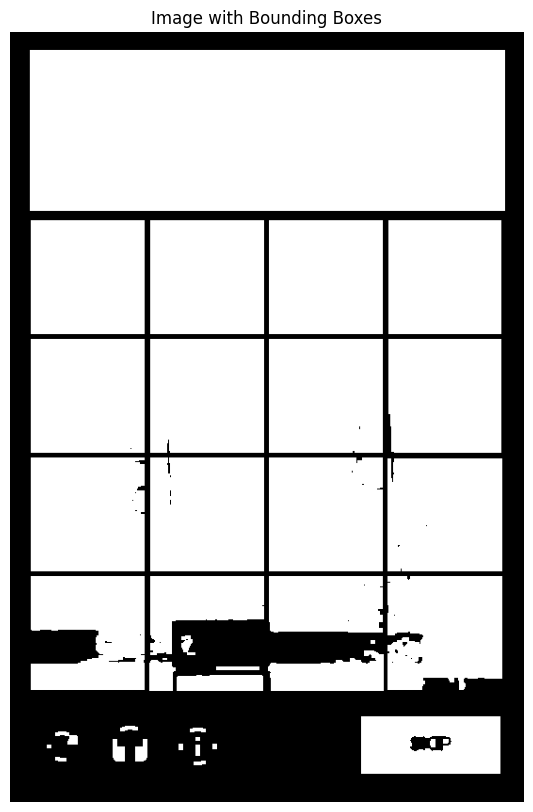

Skipping invalid box: [[  0   0   0 ...   0   0   0]
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 ...
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]]
Skipping invalid box: [[  0   0   0 ...   0   0   0]
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 ...
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]]
Skipping invalid box: [[  0   0   0 ...   0   0   0]
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 ...
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]]
Skipping invalid box: [[  0   0   0 ...   0   0   0]
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 ...
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]]
Skipping invalid box: [[  0   0   0 ...   0   0   0]
 [  0 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 ...
 [  0 255 255 ... 255 25

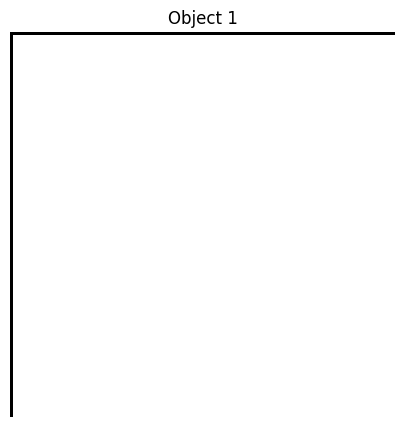

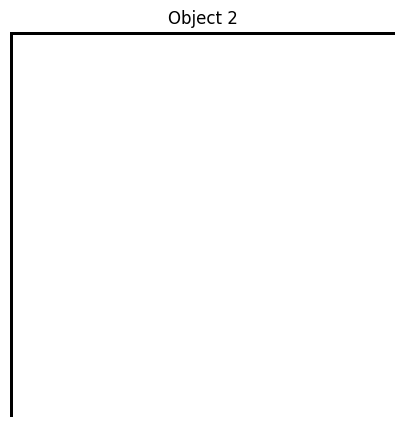

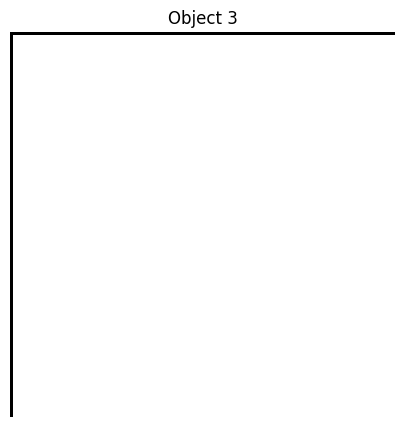

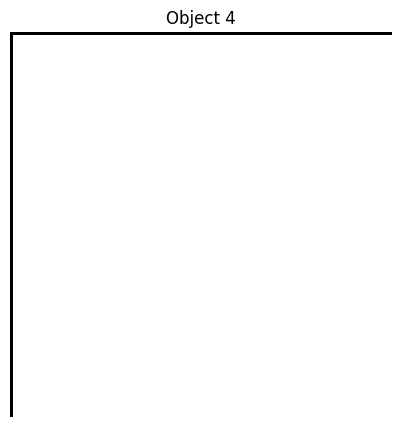

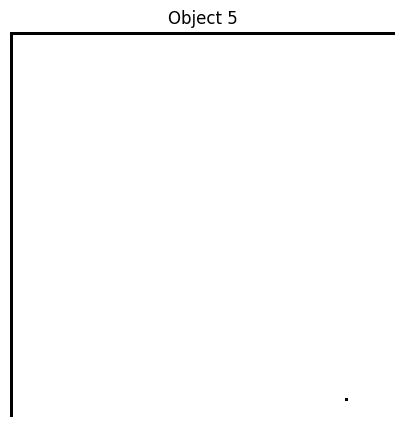

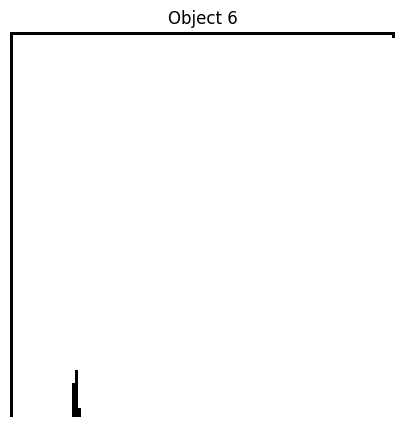

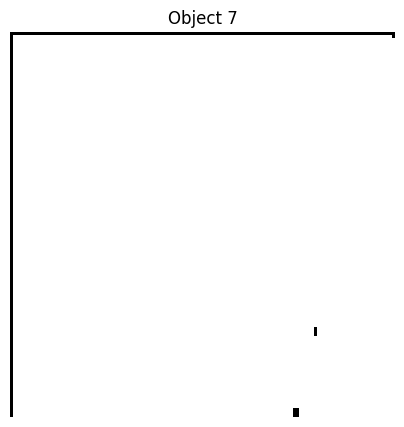

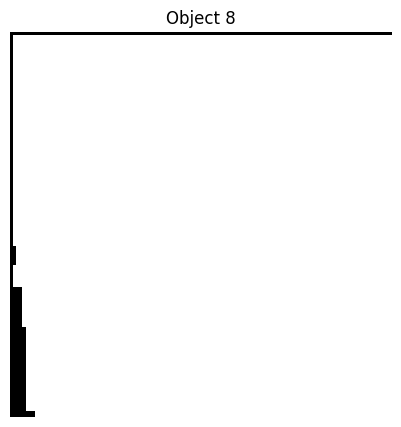

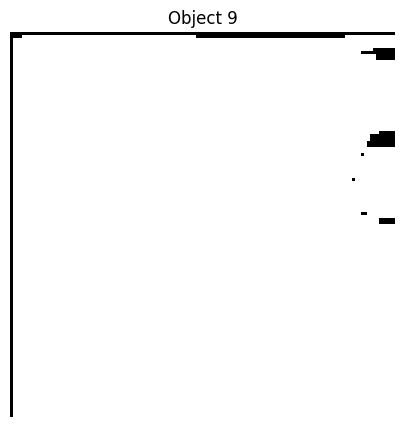

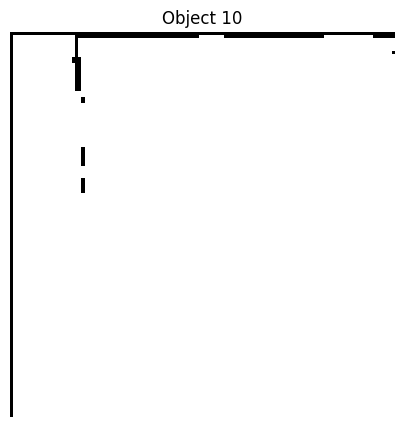

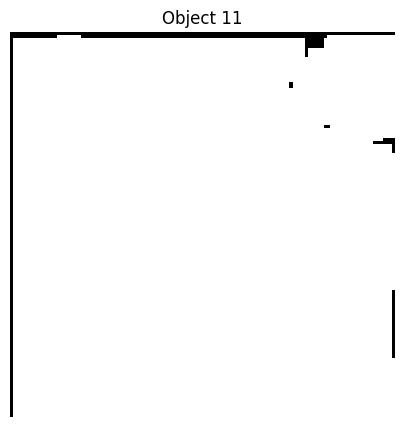

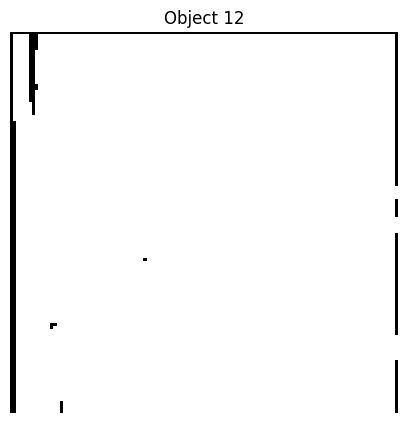

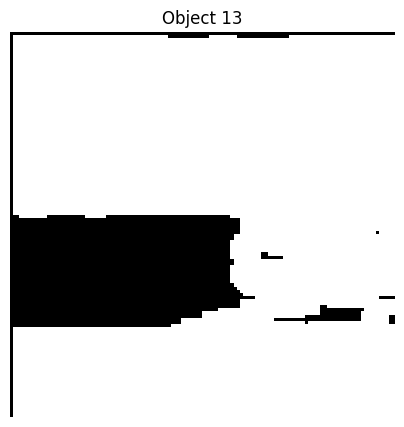

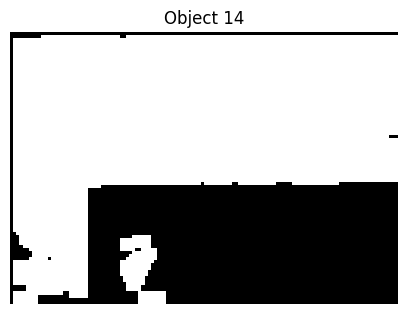

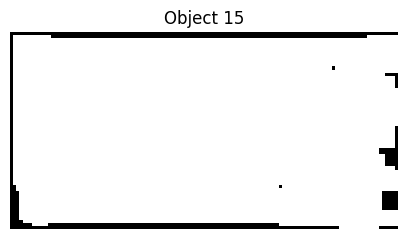

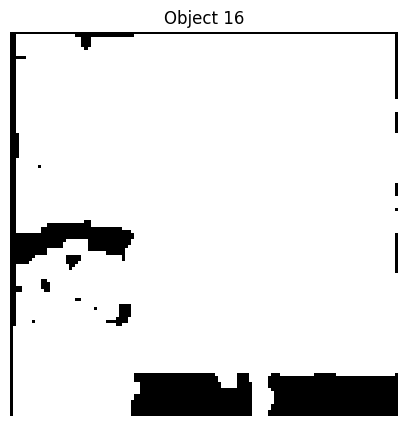

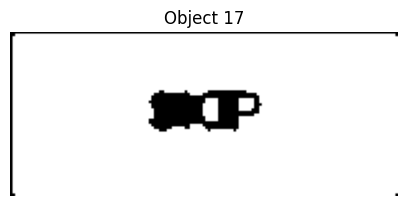

In [166]:
no_frame = erase_frame(image2)
no_grids = remove_grids(no_frame)
cols = 1
rows = 17
objects = extract_objects(no_grids, cols, rows)


for i, obj in enumerate(objects):
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(obj, cv2.COLOR_BGR2RGB))
    plt.title(f'Object {i + 1}')
    plt.axis('off')
    plt.show()

In [193]:
def detect_grid(objects):
    resized_objects = [cv2.resize(obj, (100, 100)) for obj in objects[:15]]
    
    counts = []
    for i, obj in enumerate(resized_objects):
        white_pixel_count = cv2.countNonZero(obj)
        counts.append((i, white_pixel_count))
        
    counts.sort(key=lambda x: x[1])
    min_pixels = counts[0][1]
    
    threshold = min_pixels * 1.5
    filtered_indices = [i for i, obj in enumerate(resized_objects) if counts[i][1] >= threshold]
    
    print(counts)
    print("Positions of remaining objects:", filtered_indices)
    return filtered_indices

In [194]:
detect_grid(objects)

[(13, 6631), (12, 8386), (14, 9575), (7, 9872), (11, 9901), (10, 9910), (8, 9926), (9, 9930), (5, 9998), (6, 9998), (0, 10000), (1, 10000), (2, 10000), (3, 10000), (4, 10000)]
Positions of remaining objects: [8, 9, 10, 11, 12, 13, 14]


[8, 9, 10, 11, 12, 13, 14]